In [34]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
path = '../../datasets/joint_positions_data_1000.csv'

data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         1000 non-null   float64
 1   y         1000 non-null   float64
 2   pitch     1000 non-null   float64
 3   shoulder  1000 non-null   float64
 4   elbow     1000 non-null   float64
 5   wrist     1000 non-null   float64
dtypes: float64(6)
memory usage: 47.0 KB


In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.hidden_layer = nn.Linear(3, 100)
        self.output_layer = nn.Linear(100, 3)
        self.activation_function = nn.Tanh()

    def forward(self, x):
        x = self.activation_function(self.hidden_layer(x))
        x = self.output_layer(x)
        return x



In [37]:
# -------------------------------------------
# Loading the data using pandas
# -------------------------------------------
X = data[['x', 'y', 'pitch']].to_numpy()
y = data[['shoulder', 'elbow', 'wrist']].to_numpy()

# ----------------------------------------------------------
# splitting the data into training, validation and test sets
# ----------------------------------------------------------
test_size = 0.3
batch_size = 32

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=42
)

# transforming data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test,  dtype=torch.float32)
y_test_tensor = torch.tensor(y_test,  dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

## Training a PyTorch model using stochastic gradient-descent

In [ ]:
def training_loop(training_dataloader, model, optimizer, mse):
    # accumulated the loss
    acc_loss = 0
    model.train()

    for i, (inputs, targets) in enumerate(training_dataloader):
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = mse(outputs, targets)
        loss.backward()

        # adjust learning weights
        optimizer.step()

        acc_loss += loss.item()
        # print(f'  batch {i + 1} loss: {loss.item()}')

    avg_loss = acc_loss / len(training_dataloader)
    # print(f'  average loss (training): {avg_loss}')

    return avg_loss


def test_loop(testing_dataloader, model, mse):
    model.eval()

    acc_loss = 0

    for i, (inputs, targets) in enumerate(testing_dataloader):
        outputs = model(inputs)

        loss = mse(outputs, targets)
        acc_loss += loss.item()

    avg_loss = acc_loss / len(testing_dataloader)
    # print(f'  average loss (testing): {avg_loss}')

    return avg_loss


model = FNN()
mse = nn.MSELoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.001,
    # weight_decay=0.0001
)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50

avg_train_losses = []
avg_test_losses = []

for epoch in range(epochs):
    # print(f'Epoch: {epoch+1}')
    model.train(True)
    avg_loss = training_loop(
        train_dataloader,
        model,
        optimizer,
        mse
    )
    avg_train_losses.append(avg_loss)
    avg_test_loss = test_loop(
        test_dataloader,
        model,
        mse
    )
    avg_test_losses.append(avg_test_loss)

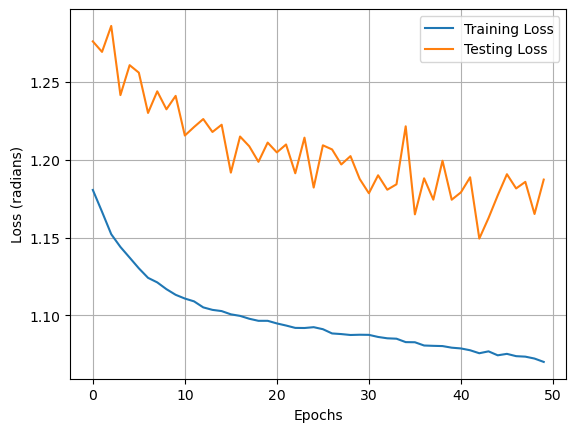

In [ ]:
# Plotting the training and testing losses over epochs
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (radians)')
# plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()

# Saving the model
torch.save(model.state_dict(), '../models/fnn_sgd_100.pth')

## Training a model using Levenberg-Marquardt

In [40]:
def training_loop_lm(train_dataloader, training_module):
    # accumulated the loss
    acc_loss = 0

    for i, (inputs, targets) in enumerate(train_dataloader):

        outputs, loss, _, _ = training_module.training_step(
            inputs,
            targets
        )

        acc_loss += loss.item()
        # print(f'  batch {i + 1} loss: {loss.item()}')

    avg_loss = acc_loss / len(train_dataloader)
    # print(f'  average loss (training): {avg_loss}')

    return avg_loss

In [ ]:
import torch_levenberg_marquardt as tlm

model = FNN()

module = tlm.training.LevenbergMarquardtModule(
    model=model,
    loss_fn=tlm.loss.MSELoss(),
    learning_rate=0.05,
    attempts_per_step=10,
    solve_method='qr',
)

epochs = 50

avg_train_losses = []
avg_test_losses = []

for epoch in range(epochs):
    # print(f'Epoch: {epoch+1}')

    avg_loss = training_loop_lm(
        train_dataloader,
        module
    )
    avg_train_losses.append(avg_loss)
    avg_test_loss = test_loop(
        test_dataloader,
        model,
        mse
    )
    avg_test_losses.append(avg_test_loss)


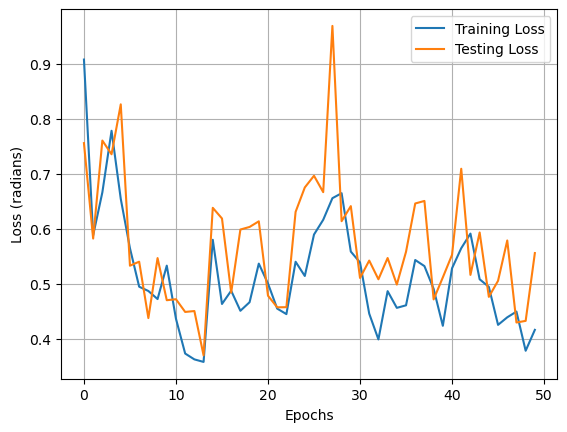

In [42]:
# Plotting the training and testing losses over epochs
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (radians)')
# plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()

# Saving the model
torch.save(model.state_dict(), '../models/fnn_lm_100.pth')